In [491]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from functools import reduce
from scipy.interpolate import make_interp_spline, BSpline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [415]:
# output only na
def sumna(df):
    columns = df.columns.tolist()
    na = df.isna().sum()
    n, m = df.shape
    print('NA 값\tN =',n)
    for i in range(m):
        if na[i] != 0:
            print('{0}: {1} ({2}%)'.format(
                columns[i],na[i],
                int(round((na[i]/n),2)*100)))
        else:
            continue

# Relative Deprivation and Risk Preference

Household debt among young Koreans has soared since COVID-19. '빚투(빚내서 투자)', which is the term for 'invest out of debt', is one of the reasons for the surge. With accelerating asset polarization more and more people are getting aggressive with investment. Scraping together wages to put into saving every month has been offset by the exponential rise in real estate prices, leading to explosive interest of younger generation in cryptocurrencies and stocks. 

According to social psychology theory, the greater the social inequality,  the more important the relative position and status becomes. The motivation to improve one's disadvantages is prioritized and the risk propensity increases as the inequality gap increases (Ermer, Cosmides, & Tooby, 2008; Hill & Bus, 2010; Mishra, Hing, & Lalumiere, 2015). Investing in safe assets with low returns does not resolve the relative wealth gap. Thus, alternative, high risk high return product, to close the social gap in a short period of time is preferred (Mishra & Lalumiere, 2010).

This notebook considers that the rapidly increasing household debt and risky assets to be caused by inequality and the effect of inequality was analyzed using the concept of 'relative deprivation', which shows similar socioeconomic characteristics. 

**Question:**

    Q1 : How does 

## Data

In [416]:
klips07h = pd.read_stata('/Users/jinc/Desktop/프로젝트/Risk_Aversion/data/klips07h.dta')
klips07p = pd.read_stata('/Users/jinc/Desktop/프로젝트/Risk_Aversion/data/klips07p.dta')
klips10h = pd.read_stata('/Users/jinc/Desktop/프로젝트/Risk_Aversion/data/klips10h.dta')
klips10p = pd.read_stata('/Users/jinc/Desktop/프로젝트/Risk_Aversion/data/klips10p.dta')

In [417]:
# concat 07 and 10 dataset
klips_h = pd.concat([klips07h, klips10h], keys=[0,1], names=['year','']).reset_index()
klips_p = pd.concat([klips07p, klips10p], keys=[0,1], names=['year','']).reset_index()

# extract household that responded for both surveys
index = pd.merge(klips07h, klips10h, left_on='hhid07', right_on='hhid10').hhid10
klips_h = klips_h[klips_h.hhid07.isin(index)].reset_index(drop=True)

# replace outliers to NaN value
klips_h.replace([-1,999999], np.NaN, inplace=True)
klips_p.replace([-1,999999], np.NaN, inplace=True)

In [418]:
for y in ['07','10']:

    # for convinient, rename individual id var
    var_id = [f'h{y}02{i}' for i in range(61,76)]
    var_id_name = [f'head{y}{i}' for i in range(1,16)]
    for v, n in zip(var_id, var_id_name):
        klips_h.rename(columns = { v:n }, inplace=True)

    # household head pid
    var_pid = [f'h{y}02{i}' for i in range(21,36)]
    for n in range(klips_h.shape[0]):
        for  m, v in enumerate(var_pid):
            if klips_h.loc[n,f'head{y}{m+1}'] == 10:
                klips_h.loc[n,'pid'] = klips_h.loc[n,v]

    # sex variable
    var_sex = [f'h{y}02{i}' for i in range(41,56)]
    for n in range(klips_h.shape[0]):
        for  m, v in enumerate(var_sex):
            if klips_h.loc[n,f'head{y}{m+1}'] == 10:
                klips_h.loc[n,'sex'] = np.where(klips_h.loc[n,v]==1, 1, 0)

    # age variable 
    var_age = [f'h{y}03{i}' for i in range(61,76)]
    for n in range(klips_h.shape[0]):
        for  m, v in enumerate(var_age):
            if klips_h.loc[n,f'head{y}{m+1}'] == 10:
                klips_h.loc[n,'age'] = klips_h.loc[n,v]

    # education variable
    var_edu = [f'h{y}06{i}' for i in range(61,76)]
    for n in range(klips_h.shape[0]):
        for  m, v in enumerate(var_edu):
            if klips_h.loc[n,f'head{y}{m+1}'] == 10:
                klips_h.loc[n,'education'] = klips_h.loc[n,v]

Extracted only one representative from each household, because the information can be bias toward individuals in big family.

In [419]:
for n, y in enumerate(['07','10']):
    # region variable
    klips_h.loc[klips_h.year==n, 'region'] = klips_h[f'h{y}0141']
    # number of household members
    klips_h.loc[klips_h.year==n, 'hsize'] = klips_h[f'h{y}0150']

    # possession status (income, asset, debt)
    # financial income possession
    klips_h.loc[klips_h.year==n, 'inc_fin'] = np.where(klips_h.loc[klips_h.year==n, f'h{y}2111']==1, 1, 0)
    # real-estate income possession
    klips_h.loc[klips_h.year==n, 'inc_est'] = np.where(klips_h.loc[klips_h.year==n, f'h{y}2121']==1, 1, 0)
    # transferred income possession
    klips_h.loc[klips_h.year==n, 'inc_tran'] = np.where(klips_h.loc[klips_h.year==n, f'h{y}2151']==1, 1, 0)
    # financial asset possession
    klips_h.loc[klips_h.year==n, 'fin_asset_y'] = np.where((klips_h.loc[klips_h.year==n, f'h{y}2561']==1) | 
                                                           (klips_h.loc[klips_h.year==n, f'h{y}2563']==1) | 
                                                           (klips_h.loc[klips_h.year==n, f'h{y}2565']==1) | 
                                                           (klips_h.loc[klips_h.year==n, f'h{y}2567']==1) | 
                                                           (klips_h.loc[klips_h.year==n, f'h{y}2569']==1) | 
                                                           (klips_h.loc[klips_h.year==n, f'h{y}2571']==1), 1, 0)
    # debt possession 
    klips_h.loc[klips_h.year==n, 'debt_y'] = np.where((klips_h.loc[klips_h.year==n, f'h{y}2601']==1) | 
                                                      (klips_h.loc[klips_h.year==n, f'h{y}2604']==1) | 
                                                      (klips_h.loc[klips_h.year==n, f'h{y}2607']==1) | 
                                                      (klips_h.loc[klips_h.year==n, f'h{y}2610']==1) | 
                                                      (klips_h.loc[klips_h.year==n, f'h{y}2613']==1) | 
                                                      (klips_h.loc[klips_h.year==n, f'h{y}2616']==1), 1, 0)

# asset and debt variable
# financial asset
var_fin = [f'h{i}25{j}' for i in ['07','10'] for j in range(62,74,2)]
klips_h['fin_asset'] = klips_h[var_fin].sum(axis=1)
# debt
var_debt = [f'h{i}260{j}' if len(str(j))==1 else f'h{i}26{j}' for i in ['07','10'] for j in range(2,20,3)]
klips_h['debt'] = klips_h[var_debt].sum(axis=1)

# income variable
# equivalent labor income
labor_income = klips_h[['h072102','h102102']].sum(axis=1)
klips_h['inc_labor'] = labor_income
klips_h['equiv_inc_labor'] = labor_income / np.sqrt(klips_h['hsize'])
# equivalent market income
var_market_1 = [f'h{i}21{j}' for i in ['07','10'] for j in range(12,17)]
var_market_2 = [f'h{i}21{j}' for i in ['07','10'] for j in range(22,27)]
var_market_3 = [f'h{i}21{j}' for i in ['07','10'] for j in range(55,61,5)]
var_market_4 = [f'h{i}2102' for i in ['07','10']]
var_market = var_market_1 + var_market_2 + var_market_3 + var_market_4
klips_h['inc_market'] = klips_h[var_market].sum(axis=1)
klips_h['equiv_inc_market'] = klips_h['inc_market'] / np.sqrt(klips_h['hsize'])


In [420]:
klips_h.inc_labor.replace(np.NaN, 0, inplace=True)
klips_h.equiv_inc_labor.replace(np.NaN, 0, inplace=True)
klips_h = klips_h[klips_h.equiv_inc_market>0]

In [421]:
# obsevation with errors
# debt_y == 1 (have debt) but debt == 0 (actual debt amount == 0)
print('debt error: ', klips_h[(klips_h.debt_y==1) & (klips_h.debt==0)].shape[0])
klips_h.loc[(klips_h.debt_y==1) & (klips_h.debt==0),'debt'] = np.NaN
# fin_asset_y == 1 (have financial asset) but fin_asset == 0 (actual financial asset amount == 0)
print('financial asset error: ', klips_h[(klips_h.fin_asset_y==1) & (klips_h.fin_asset==0)].shape[0])
klips_h.loc[(klips_h.fin_asset_y==1) & (klips_h.fin_asset==0),'fin_asset'] = np.NaN

debt error:  30
financial asset error:  50


In [422]:
# merge household and individual dataset
klips = pd.merge(klips_h, klips_p, how='left', on=['pid','year'])

# martial status(with or without partner) variable
klips['martial'] = np.where((klips['p075501']==2) | (klips['p105501']==2), 1, 0)
# risk related variable
for n, y in enumerate(['07','10']):
    klips.loc[klips.year==n,'risk1'] = klips[f'p{y}6401']
    klips.loc[klips.year==n,'risk2'] = klips[f'p{y}6402']
    klips.loc[klips.year==n,'risk3'] = klips[f'p{y}6403']
    klips.loc[klips.year==n,'risk4'] = klips[f'p{y}6404']
    klips.loc[klips.year==n,'risk5'] = klips[f'p{y}6405']
    # satisfaction (social interaction)
    klips.loc[klips.year==n,'satisfaction'] = klips[f'p{y}6506']

# replace outliers to NaN value
klips[['risk1','risk2','risk3','risk4','risk5']] = klips[['risk1','risk2','risk3','risk4','risk5']].replace(9, np.NaN)

In [423]:
var = ['pid','year','sex','age','education','martial','region','hsize','equiv_inc_labor','inc_labor','equiv_inc_market','inc_market','inc_fin','inc_est','inc_tran','fin_asset','debt','satisfaction','risk1','risk2','risk3','risk4','risk5']
klips = klips[var]

In [424]:
sumna(klips)

NA 값	N = 7578
education: 1 (0%)
fin_asset: 50 (1%)
debt: 30 (0%)
satisfaction: 186 (2%)
risk1: 196 (3%)
risk2: 196 (3%)
risk3: 198 (3%)
risk4: 199 (3%)
risk5: 198 (3%)


In [425]:
klips.describe()

,pid,year,sex,age,education,martial,region,hsize,equiv_inc_labor,inc_labor,equiv_inc_market,inc_market,inc_fin,inc_est,inc_tran,fin_asset,debt,satisfaction,risk1,risk2,risk3,risk4,risk5
count,7578.000000,7578.000000,7578.000000,7578.000000,7577.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7578.000000,7528.000000,7548.000000,7392.000000,7382.000000,7382.000000,7380.000000,7379.00000,7380.000000
mean,276780.556215,0.499604,0.854579,49.708102,5.023228,0.778306,6.548430,3.339272,1606.113592,2948.036157,1769.940321,3226.893639,0.108472,0.112695,0.424254,1907.622476,3373.723238,2.577381,1.142509,1.123679,1.095122,1.13701,1.097832
std,158015.569849,0.500033,0.352548,12.914028,1.514533,0.415414,4.632128,1.252830,1218.856330,2388.945067,1914.296911,3397.256028,0.310996,0.316240,0.494262,6634.549574,8844.629436,0.600336,0.404567,0.374662,0.342029,0.38656,0.346779
min,101.000000,0.000000,0.000000,20.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.707107,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
25%,145303.000000,0.000000,1.000000,39.000000,4.000000,1.000000,2.000000,2.000000,810.000000,1380.000000,866.025404,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000
50%,278102.000000,0.000000,1.000000,49.000000,5.000000,1.000000,7.000000,4.000000,1385.640646,2420.000000,1450.000000,2549.000000,0.000000,0.000000,0.000000,400.000000,500.000000,3.000000,1.000000,1.000000,1.000000,1.00000,1.000000
75%,408651.500000,1.000000,1.000000,59.000000,6.000000,1.000000,10.000000,4.000000,2100.000000,3871.500000,2200.000000,4020.000000,0.000000,0.000000,1.000000,1952.500000,3300.000000,3.000000,1.000000,1.000000,1.000000,1.00000,1.000000
max,640802.000000,1.000000,1.000000,91.000000,9.000000,1.000000,16.000000,10.000000,18000.000000,36000.000000,70965.236560,104680.000000,1.000000,1.000000,1.000000,240000.000000,220000.000000,5.000000,3.000000,3.000000,3.000000,3.00000,3.000000


## Relative Deprivation

The concept of relative deprivation has existed in the economic literatures for a while and it has been used as a proxy for income inequality because as inequality increases, the gap between the 'haves' and the 'have nots' grows, as well as the overall deprivation in the society. 

### Reference group

Relative deprivation refers to feelings of resentment and dissatisfaction resulting from the belief that an individual has been deprived of the desired or desirable outcome compared to other comparative groups (Callan, Shead & Olson, 2011). Thus, in order to address relative deprivation, it is important to clearly define the reference groups. 

The social psychology literature suggest that reference group to be selected upon similarity or geographic proximity (Singer 1981). Therefore, in this study, the reference groups were defined based on similarities in demographic characteristics(age, educational background) and geographical characteristic. 

To secure enough number of observation, the groups with few observations(N<10) are merged into the nearest groups. The observations are classified into 46 different reference groups with the average group size of 266 observations.

In [426]:
# age group (19~35, 35~50, 50~65, 65+)
bins = [19,35,50,65,100]
labels = [1,2,3,4]
age_group = pd.cut(klips['age'], bins=bins, labels=labels, right=False)
age_group = age_group.astype('float32')

# education group (middle school and below, highschool, college and above)
education_group = klips.education
education_group.replace([1,2,3,4], 1, inplace=True)
education_group.replace(5, 2, inplace=True)
education_group.replace([6,7,8,9], 3, inplace=True)

# region group (seoul, city, 경기도, other)
region_group = klips.region
region_group.replace([2,3,4,5,6,7], 2, inplace=True)
region_group.replace(8, 3, inplace=True)
region_group.replace([9,10,11,12,13,14,15,16,17,18,19], 4, inplace=True)

klips['group'] = (age_group*100) + (education_group*10) + (region_group)
klips.group.replace([113,114], 112, inplace=True)

In [427]:
print('Number of groups: ', klips.group.nunique())
print('Average group size: ',klips.group.mean())

Number of groups:  46
Average group size:  272.2064141480797


### Measurement

**Yitzhaki Index**

$Yitzhaki_i = \frac{1}{N} \Sigma(y_j - y_i)I_{ij}$ 
$$I_{ij}\begin{cases}
1, & y_j > y_i \\
0, & y_j \le y_i
\end{cases}$$

The first measurement is proposed by Yitzhaki(1979), where N is the total number of individuals in each reference group. RD will increase for the sum of all income differences between individual $i$ and for all $j$ with income greater than individual $i$.

In [428]:
# Yitzhaki Index
gid = klips.group.unique()
result = []
# for each group
for g in gid:
    # for each year
    for y in [0,1]:
        group = klips[(klips.group == g) & (klips.year == y)].reset_index(drop=True).copy()
        N = group.shape[0]
        # for each individual i
        for i in range(N):
            diff = 0
            # for each individual j
            for j in range(N):
                # get difference only if j is greater than i
                if (group.loc[i,'equiv_inc_labor'] < group.loc[j,'equiv_inc_labor']):
                    diff += (group.loc[j,'equiv_inc_labor'] - group.loc[i,'equiv_inc_labor'])
            result.append([group.loc[i,'pid'], y, (diff/N)])

yitzhaki = pd.DataFrame(result, columns=['pid','year','yitzhaki'])
klips = pd.merge(klips, yitzhaki, how='left', on=['pid','year'])

**Deaton Index**

$Deaton_i = \frac{1}{N\mu} \Sigma(y_j - y_i)I_{ij}$ 
$$I_{ij}\begin{cases}
1, & y_j > y_i \\
0, & y_j \le y_i
\end{cases}$$

Deaton index (Deaton, 2001) is same as Yitzhaki index but scaled by the mean income of the reference group. Normalizing $(y_j - y_i)$ by $\mu$ allows the index to capture the total community income. 

In [429]:
# Deaton Index
gid = klips.group.unique()
result = []
# for each group
for g in gid:
    # for each year
    for y in [0,1]:
        group = klips[(klips.group == g) & (klips.year == y)].reset_index(drop=True).copy()
        N = group.shape[0]
        # for each individual i
        for i in range(N):
            diff = 0
            # for each individual j
            for j in range(N):
                # get difference only if j is greater than i
                if (group.loc[i,'equiv_inc_labor'] < group.loc[j,'equiv_inc_labor']):
                    diff += (group.loc[j,'equiv_inc_labor'] - group.loc[i,'equiv_inc_labor'])
            # mean income
            mean_income = group.equiv_inc_labor.mean()
            result.append([group.loc[i,'pid'], y, (diff/(N*mean_income))])

deaton = pd.DataFrame(result, columns=['pid','year','deaton'])
klips = pd.merge(klips, deaton, how='left', on=['pid','year'])

**Income Rank**

$Rank_i = \frac{i-1}{N-1}$

Next is just an ordinary income rank within the reference group. The assumption of Yitzhaki Index is that individual know the exact amount of income they are away from others (Boyce et al., 2010). To ease this assumption, the income rank is used. The concept of income rank is that individual form an idea about their relative position by rough information conferred by income (Pak & Choung, 2020). 

In [430]:
# Rank
gid = klips.group.unique()
result = []
# for each group 
for g in gid:
    # for each year
    for y in [0,1]:
        group = klips[(klips.group == g) & (klips.year == y)].sort_values(by='equiv_inc_labor').reset_index(drop=True)
        group = group.reset_index().rename(columns={'index':'rank'})
        N = group.shape[0]
        # for each individual i
        for i in range(N):
            # |rank-1| to change index characteristic same as other index(value increase as RD increase).
            ranks = 1 - ((group.loc[i,'rank']) / (N - 1))
            result.append([group.loc[i,'pid'], y, ranks])

rank = pd.DataFrame(result, columns=['pid','year','rank'])
klips = pd.merge(klips, rank, how='left', on=['pid','year'])

In [431]:
klips[['yitzhaki','deaton','rank']].describe()

,yitzhaki,deaton,rank
count,7577.000000,7577.000000,7577.000000
mean,532.468600,0.349280,0.500000
std,433.159049,0.266442,0.292299
min,0.000000,0.000000,0.000000
25%,203.992292,0.136117,0.246835
50%,435.640866,0.289472,0.500000
75%,752.261950,0.506380,0.753165
max,2977.986501,1.000000,1.000000


In [432]:
klips['edu_group'] = education_group
for edu, val in zip(['highschool','college'], [2,3]):
    klips[edu] = klips.edu_group == val
klips[['highschool','college']] = klips[['highschool','college']].astype('int16')

## Risk Preference

To measure risk preference, the following survey question from KLIPS was used:

**Q: Which would you choose between cash and instant lottery when the rewards and odds of winning the lotteries are:**
<style>
    li{
   display:block;
   float:left;
   padding: 15px; /*adjust*/
}
</style>
<ol>
    <li>1) ₩100,000 Cash</li>
    <li>2) Lottery</li>
    <li>3) Doesn't matter</li>
</ol>



<style>
table,td,tr,th {border:none!important}
td {padding-left:20px; padding-right:20px; font-size:12px;}
</style>

<table>
    <tr>
        <th>Scenario</th>
        <th>Prize1 / Prob.</th>
        <th>Prize2 / Prob.</th>
    </tr>
    <tr>
        <td>1</td>
        <td>₩150k / 50%</td>
        <td>₩50k / 50%</td>
    </tr>
    <tr>
        <td>2</td>
        <td>₩200k / 50%</td>
        <td>₩0 / 50%</td>
    </tr>
    <tr>
        <td>3</td>
        <td>₩200k / 40%</td>
        <td>₩0 / 60%</td>
    </tr>
    <tr>
        <td>4</td>
        <td>₩200k / 60%</td>
        <td>₩0 / 40%</td>
    </tr>
    <tr>
        <td>5</td>
        <td>₩500k / 20%</td>
        <td>₩0 / 80%</td>
    </tr>
</table>

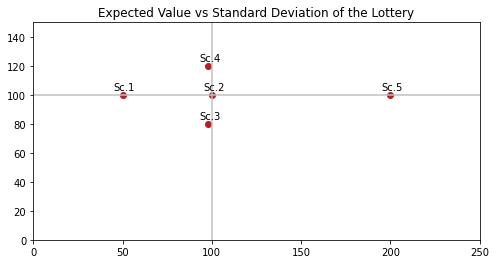

In [433]:
lot = np.array([
                [150,0.5,50,0.5],
                [200,0.5,0,0.5],
                [200,0.4,0,0.6],
                [200,0.6,0,0.4],
                [500,0.2,0,0.8]
                ])
ev = []
std = []
for i in range(0,5):
    E = lot[i,0]*lot[i,1] + lot[i,2]*lot[i,3]
    S = np.sqrt((np.square(E-lot[i,0])*lot[i,1] + np.square(E-lot[i,2])*lot[i,3]))
    ev.append(E)
    std.append(round(S))

plt.figure(figsize=(8,4))
plt.title('Expected Value vs Standard Deviation of the Lottery')
plt.scatter(std, ev, color='firebrick')
plt.vlines(100, 0, 150, color='silver')
plt.hlines(100, 0, 250, color='silver')
plt.text(45, 103, 'Sc.1')
plt.text(95, 103, 'Sc.2')
plt.text(93, 83, 'Sc.3')
plt.text(93, 123, 'Sc.4')
plt.text(195, 103, 'Sc.5')
plt.xlim([0,250])
plt.ylim([0,150])
plt.show()

Scenario 1, 2, and 5 have the same expected value of ₩100k, but the riskiness of each lottery differs. Looking at the standard deviation, we can order the riskiness of the lotteries by 

$Sc.1 < Sc.2 < Sc.5$

On the other hand, Scenario 3 and 4 have the same riskiness with different expected values and we can also order them by the following

$Sc.4 < Sc.3$

In [434]:
tab_all = pd.DataFrame({'choice':['Cash','Lottery','Dsnt Matter']})
for i in range(1,6):
    tab = pd.crosstab(index=klips[f'risk{i}'], columns='count').rename(columns={'count':f'Sc.{i}'}).reset_index(drop=True)
    tab_all = pd.concat([tab_all, tab], axis=1)
tab_all.set_index('choice', inplace=True)
round(tab_all / klips.shape[0] * 100, 2)

,Sc.1,Sc.2,Sc.3,Sc.4,Sc.5
choice,,,,,
Cash,85.55,86.92,89.63,85.55,89.42
Lottery,9.84,8.93,6.25,10.31,6.41
Dsnt Matter,2.02,1.56,1.50,1.52,1.56


1) $Sc.1 < Sc.2 < Sc.5$

    We can see that at the scenario with the lowest risk(scenario 1) **85.55%** of the respondent **preferred cash** and **9.84% preferred risky asset(lottery)**. As the **risk increases**, the proportion of people preferring **cash increases** by 1.37%(Sc.2) and 2.5%(Sc.2 to Sc.5). However, proportion of **lottery preference** tend to **decrease** by 0.91%(Sc.2) and 2.52%(Sc.2 to Sc.5).

2) $Sc.4 < Sc.3$

    The same characteristics are also found between Sc.3 and 4. risk increase(Sc4 to Sc3), the preference of cash increases by 4.08% and the preference for lottery decreases by 4.06%.


Looking at the **tendencies of group selection**, we can conclude that 

**as risk increases:**

        1. the frequency of people choosing cash will increase
        
        2. the frequency of people choosing lottery will decrease. 

and base on this we can order the scenario as follows

$Sc.1 \approx Sc.4 < Sc.2 < Sc.3 \approx Sc.5$

In [435]:
# reordering risk variables 
# 1) cash = 0   2) doesn't matter = 1   3) lottery = 2
for i in range(1,6):
    klips[f'risk{i}'].replace(1, 0, inplace=True)
    klips[f'risk{i}'].replace(3, 1, inplace=True)

klips['risk'] = (klips.risk1*0.1) + (klips.risk2*0.2) + (klips.risk5 *0.35)  + (klips.risk3*0.25) + (klips.risk4*0.1)

$Risk = \Sigma\alpha_i(risk)_i$

To summarize 5 risk related question into 1 indicator, each variables are weighted($\alpha$) base on the order above.

## Model

To measure how relative deprivation affect risk preference, the following expression is used

$Risk_{it} = \beta_0 + \beta_1Relative Deprivation_{it} + X_{it} + \gamma_1 \delta_1 + e_{it}$

The dependent variable $Risk_{it}$ represents the risk propensity of the individual $i$ in the $t^{th}$ year. $Relative Deprivation_{it}$ is the main independent variable and represents the degree of relative deprivation of an individual. In addition, $X_{it}$ is a vector of other explanatory variables(demographic characteristics, equalized income, asset and debt amount, etc.) that affects the dependent variable. Lastly, $\delta$ is the time dummy variable and $e_{it}$ is the error term that implies all the variables except the independent and other explanatory variables. 

if the estimated coefficient $\beta_1$ is greater than 0($\beta_1 > 0$), it means that those with higher relative deprivation have a risk-preferred tendency than those with lower risk. Conversely, if the estimated coefficient $\beta_1$ is less than 0 ($\beta_1 < 0$), the lower the relative deprivation, the more risk-preferred tendency appears.

### Feature engineering

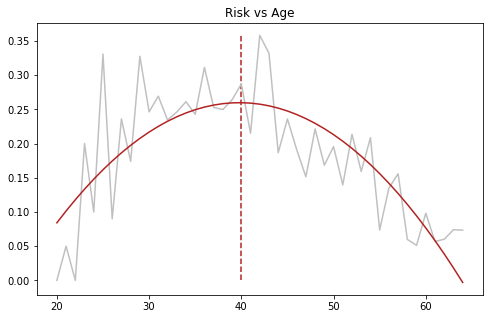

In [551]:
risk_age = klips.groupby('age').mean().risk
x = risk_age.index
y = risk_age.values

x_poly = np.column_stack((x**2, x))
lr = LinearRegression()
lr.fit(x_poly, y)
x_new = np.arange(20,65)

plt.figure(figsize=(8,5))
plt.title('Risk vs Age')
plt.plot(x,y, color='silver')
plt.plot(x_new, lr.intercept_ + lr.coef_[0]*x_new**2 + lr.coef_[1]*x_new, color='firebrick')

pick = list(y_new).index(y_new.max())
plt.vlines(x_new[pick], y.min(), y.max(), color='firebrick', linestyles='dashed')

plt.show()

In [ ]:
# found quadratic relationship between age and risk preference
klips['age2'] = klips.age**2

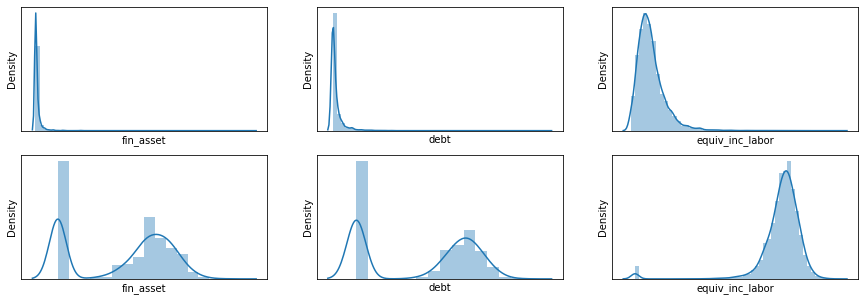

In [558]:
f,ax = plt.subplots(2,3, figsize=(15,5))
# skewed variables
sns.distplot(klips.fin_asset, ax=ax[0,0])
sns.distplot(klips.debt, ax=ax[0,1])
sns.distplot(klips.equiv_inc_labor, ax=ax[0,2])
# apply logarithm
sns.distplot(np.log(klips.fin_asset+1), ax=ax[1,0])
sns.distplot(np.log(klips.debt+1), ax=ax[1,1])
sns.distplot(np.log(klips.equiv_inc_labor+1), ax=ax[1,2])

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

plt.show()

<AxesSubplot:xlabel='debt', ylabel='Density'>

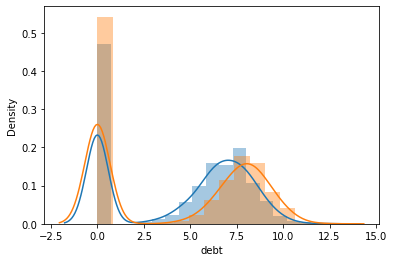

In [438]:
klips['log_fin_asset'] = np.log(klips.fin_asset+1)
klips['log_debt'] = np.log(klips.debt+1)
klips['log_equiv_inc'] = np.log(klips.equiv_inc_labor+1)

In [439]:
klips['age2'] = klips.age**2

klips['log_yitzhaki'] = np.log(klips.yitzhaki+1)
klips['log_deaton'] = np.log(klips.deaton+1)
klips['log_equiv_inc'] = np.log(klips.equiv_inc_labor+1)
klips['log_fin_asset'] = np.log(klips.fin_asset+1)
klips['log_debt'] = np.log(klips.debt+1)

In [562]:
klips['rank']

0       0.586207
1       0.722222
2       0.168831
3       0.506494
5       0.758621
          ...   
7573    0.942529
7574    0.676471
7575    0.294118
7576    0.853659
7577    0.012579
Name: rank, Length: 6430, dtype: float64

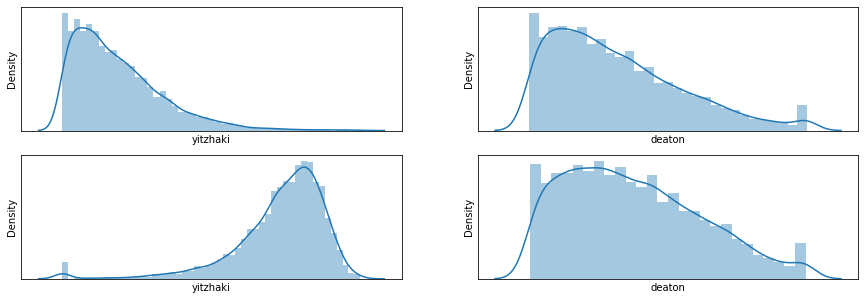

In [566]:
f,ax = plt.subplots(2,2, figsize=(15,5))
# skewed variables
sns.distplot(klips.yitzhaki, ax=ax[0,0])
sns.distplot(klips.deaton, ax=ax[0,1])
# apply logarithm
sns.distplot(np.log(klips.yitzhaki+1), ax=ax[1,0])
sns.distplot(np.log(klips.deaton+1), ax=ax[1,1])

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

plt.show()

In [573]:
# klips = klips[klips.inc_labor>0]
klips = klips[klips.age<65]

### Analysis

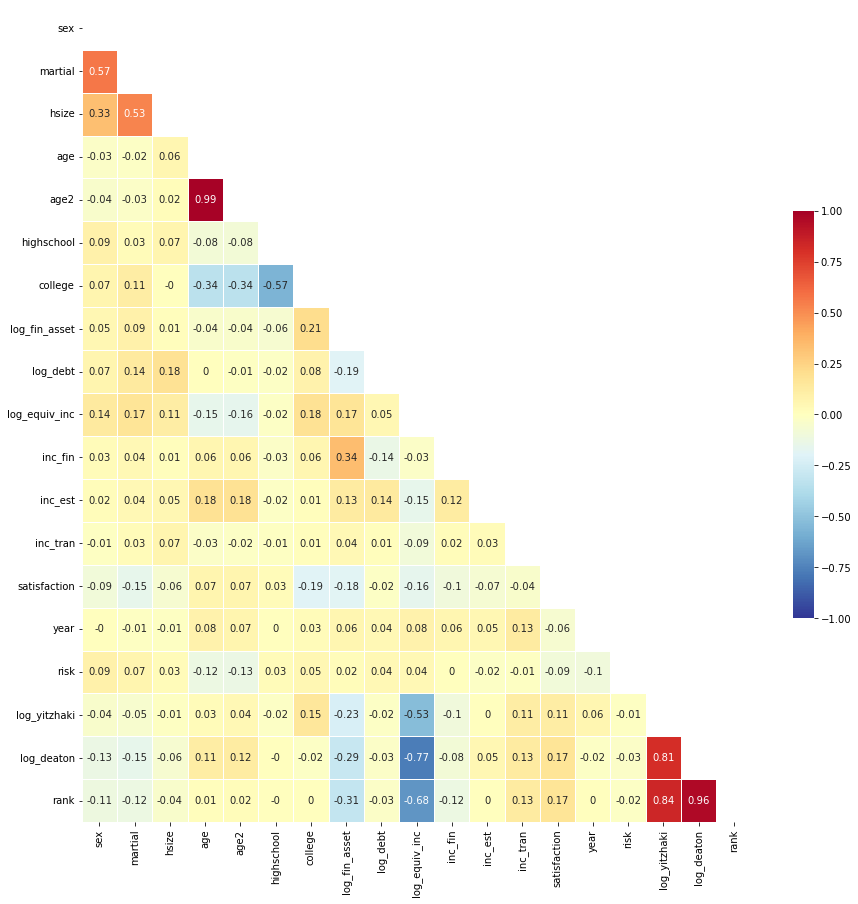

In [583]:
var_analysis = ['sex','martial','hsize','age','age2','highschool','college','log_fin_asset','log_debt','log_equiv_inc','inc_fin','inc_est','inc_tran','satisfaction','year','risk','log_yitzhaki','log_deaton','rank']

corr = round(klips[var_analysis].corr(),2)

fig, ax = plt.subplots( figsize=(15,15) )


mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   
            mask=mask,      
            linewidths=.5,  
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1  
           )  
plt.show()

In [572]:
smf.ols(formula='risk ~ log_yitzhaki + sex + martial + hsize + age + age2 + highschool + college + log_fin_asset + log_debt + log_inc_labor + inc_fin + inc_est + inc_tran + satisfaction + year', data=klips, missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   risk   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     17.04
Date:                Fri, 10 Jun 2022   Prob (F-statistic):           1.58e-47
Time:                        21:09:11   Log-Likelihood:                -4434.5
No. Observations:                6185   AIC:                             8903.
Df Residuals:                    6168   BIC:                             9017.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0794      0.156     -0.510      0.610      -0.385       0.226
log_yitzhaki      0.0119      0.007      1.769      0.077      -0.001       0.025
sex               0.1109      0.024      4.651      0.000       0.064       0.158
martial           0.0110      0.024      0.464      0.642      -0.035       0.057
hsize            -0.0109      0.007     -1.531      0.126      -0.025       0.003
age               0.0189      0.006      2.963      0.003       0.006       0.031
age2             -0.0003    6.9e-05     -3.825      0.000      -0.000      -0.000
highschool        0.0112      0.018      0.627      0.530      -0.024       0.046
college          -0.0069      0.022     -0.322      0.747      -0.049       0.035
log_fin_asset     0.0024      0.002      1.132      0.257      -0.002       0.007
log_debt          0.0052      0.002      3.104      0.002       0.002       0.009
log_inc_labor     0.0066      0.007      0.924      0.356      -0.007       0.020
inc_fin           0.0162      0.023      0.701      0.483      -0.029       0.062
inc_est          -0.0202      0.024     -0.840      0.401      -0.067       0.027
inc_tran         -0.0056      0.014     -0.411      0.681      -0.032       0.021
satisfaction     -0.0702      0.011     -6.277      0.000      -0.092      -0.048
year             -0.1035      0.013     -7.904      0.000      -0.129      -0.078
==============================================================================
Omnibus:                     3152.970   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15423.872
Skew:                           2.559   Prob(JB):                         0.00
Kurtosis:                       8.801   Cond. No.                     5.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [575]:
smf.ols(formula='risk ~ deaton + sex + martial + hsize + age + age2 + highschool + college + log_fin_asset + log_debt + log_inc_labor + inc_fin + inc_est + inc_tran + satisfaction + year', data=klips).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   risk   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     16.94
Date:                Fri, 10 Jun 2022   Prob (F-statistic):           3.28e-47
Time:                        21:11:01   Log-Likelihood:                -4435.3
No. Observations:                6185   AIC:                             8905.
Df Residuals:                    6168   BIC:                             9019.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0564      0.158     -0.358      0.720      -0.366       0.253
deaton            0.0614      0.049      1.261      0.207      -0.034       0.157
sex               0.1122      0.024      4.696      0.000       0.065       0.159
martial           0.0117      0.024      0.495      0.621      -0.035       0.058
hsize            -0.0111      0.007     -1.527      0.127      -0.025       0.003
age               0.0190      0.006      2.979      0.003       0.007       0.032
age2             -0.0003   6.91e-05     -3.837      0.000      -0.000      -0.000
highschool        0.0140      0.018      0.792      0.429      -0.021       0.049
college          -0.0008      0.021     -0.036      0.971      -0.042       0.040
log_fin_asset     0.0023      0.002      1.066      0.286      -0.002       0.006
log_debt          0.0051      0.002      3.034      0.002       0.002       0.008
log_inc_labor     0.0092      0.010      0.951      0.342      -0.010       0.028
inc_fin           0.0144      0.023      0.621      0.535      -0.031       0.060
inc_est          -0.0214      0.024     -0.893      0.372      -0.068       0.026
inc_tran         -0.0058      0.014     -0.424      0.671      -0.033       0.021
satisfaction     -0.0700      0.011     -6.250      0.000      -0.092      -0.048
year             -0.1016      0.013     -7.810      0.000      -0.127      -0.076
==============================================================================
Omnibus:                     3152.010   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15405.571
Skew:                           2.559   Prob(JB):                         0.00
Kurtosis:                       8.796   Cond. No.                     6.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [576]:
smf.ols(formula='risk ~ rank + sex + martial + hsize + age + age2 + highschool + college + log_fin_asset + log_debt + log_inc_labor + inc_fin + inc_est + inc_tran + satisfaction + year', data=klips).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   risk   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     16.97
Date:                Fri, 10 Jun 2022   Prob (F-statistic):           2.66e-47
Time:                        21:11:10   Log-Likelihood:                -4435.1
No. Observations:                6185   AIC:                             8904.
Df Residuals:                    6168   BIC:                             9019.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0546      0.155     -0.353      0.724      -0.358       0.248
rank              0.0455      0.032      1.424      0.154      -0.017       0.108
sex               0.1120      0.024      4.690      0.000       0.065       0.159
martial           0.0113      0.024      0.477      0.633      -0.035       0.058
hsize            -0.0110      0.007     -1.530      0.126      -0.025       0.003
age               0.0193      0.006      3.024      0.003       0.007       0.032
age2             -0.0003   6.91e-05     -3.856      0.000      -0.000      -0.000
highschool        0.0153      0.017      0.874      0.382      -0.019       0.050
college           0.0012      0.020      0.057      0.955      -0.039       0.041
log_fin_asset     0.0024      0.002      1.115      0.265      -0.002       0.007
log_debt          0.0051      0.002      3.057      0.002       0.002       0.008
log_inc_labor     0.0071      0.008      0.893      0.372      -0.008       0.023
inc_fin           0.0152      0.023      0.656      0.512      -0.030       0.061
inc_est          -0.0211      0.024     -0.878      0.380      -0.068       0.026
inc_tran         -0.0058      0.014     -0.424      0.672      -0.033       0.021
satisfaction     -0.0703      0.011     -6.270      0.000      -0.092      -0.048
year             -0.1023      0.013     -7.842      0.000      -0.128      -0.077
==============================================================================
Omnibus:                     3151.891   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15404.586
Skew:                           2.559   Prob(JB):                         0.00
Kurtosis:                       8.796   Cond. No.                     5.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""